In [1]:
from __future__ import print_function

import math
from functools import partial

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.python.data import Dataset

tf.get_logger().setLevel('ERROR')
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [2]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"]]
    
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
    return processed_features    

In [3]:
def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [5]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


In [6]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [7]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


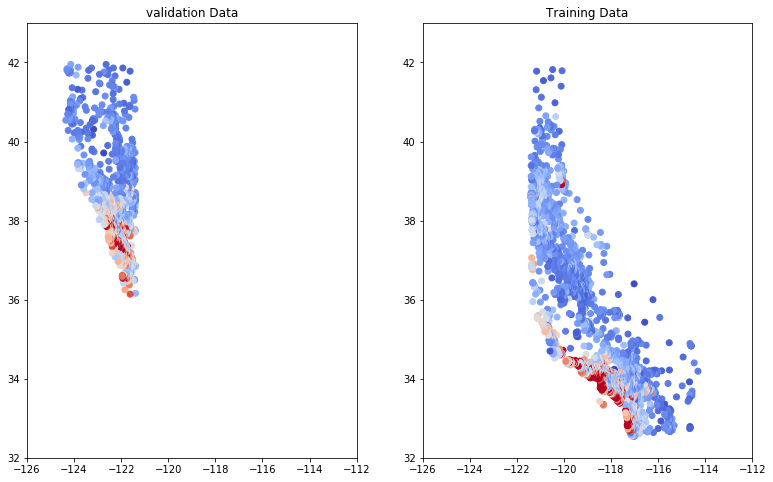

In [13]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1,2,1)
ax.set_title("validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])

plt.scatter(validation_examples["longitude"],
           validation_examples["latitude"],
           cmap="coolwarm",
           c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])

plt.scatter(training_examples["longitude"],
           training_examples["latitude"],
           cmap="coolwarm",
           c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

_ = plt.plot()

검증 데이터와 훈련 데이터의 위치 정보를 전시해본 결과 검증 데이터의 위치가 편향되어 있음을 확인할 수 있다. 
아마도 검증 데이터 선택에 무작위 성이 부족한 것 같다.

In [15]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [17]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [27]:
def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    my_optimizer = partial(optimizers.SGD, learning_rate=learning_rate, clipnorm=5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
    
    training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    
    for period in range (0, periods):
        linear_regressor.train(input_fn=training_input_fn, steps=steps_per_period)
        
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        print("  period %d : %f" % (period, training_root_mean_squared_error))
        
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model training finished.")
    
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

Training model...
RMSE (on training data):
  period 0 : 194.480484
  period 1 : 172.984433
  period 2 : 161.898554
  period 3 : 159.006168
  period 4 : 158.544813
  period 5 : 160.123456
  period 6 : 160.933190
  period 7 : 161.248738
  period 8 : 161.958489
  period 9 : 161.866257
Model training finished.


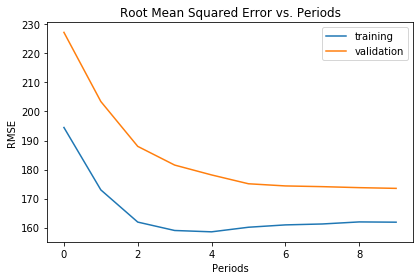

In [32]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [33]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(test_examples, test_targets["median_house_value"], num_epochs=1, shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %f" % root_mean_squared_error)

Final RMSE (on test data): 157.910197
